In [1]:
#pip install label-studio

#this is the line for reference to start the label-studio local machine
#label-studio start

In [17]:
#code written by Matthew Miller (adapted from chatGPT and prior code from class)

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models

import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

import random
import itertools

from collections import defaultdict

## Set the image folder and read the CSV file (the CSV files and the images must be in a single folder)

In [3]:
# Folder containing the image files and the corresponding CSV file
folder_path = "Glaucoma_Balanced_Dataset/JustRAIGS"
csv_file = "JustRAIGS_Train_labels_balance.csv"
csv_path = os.path.join(folder_path,csv_file)
print(csv_path)

# Read the CSV file containing the image filenames and classifications
data = pd.read_csv(csv_path)
#print(data)

Glaucoma_Balanced_Dataset/JustRAIGS\JustRAIGS_Train_labels_balance.csv


In [10]:
# Function to find the smallest horizontal and vertical pixel values in a dataset
def find_smallest_pixel_values(dataset_folder):
    smallest_horizontal = float('inf')
    smallest_vertical = float('inf')

    # Iterate over all files in the dataset folder
    for filename in os.listdir(dataset_folder):
        if filename.endswith(".jpg"):
            # Read the image using OpenCV
            image_path = os.path.join(dataset_folder, filename)
            image = cv2.imread(image_path)

            if image is not None:
                # Get image dimensions (height and width)
                height, width, _ = image.shape

                # Update smallest horizontal and vertical pixel values
                if width < smallest_horizontal:
                    smallest_horizontal = width
                
                if height < smallest_vertical:
                    smallest_vertical = height

    return smallest_horizontal, smallest_vertical

# Example usage:
smallest_horizontal, smallest_vertical = find_smallest_pixel_values(folder_path)

print("Smallest horizontal pixel value:", smallest_horizontal)
print("Smallest vertical pixel value:", smallest_vertical)


Smallest horizontal pixel value: 1024
Smallest vertical pixel value: 682


In [ ]:
## The output of the above line of code for the balanced data set is as follows:
# Smallest horizontal pixel value: 1024
# Smallest vertical pixel value: 682

# There are only 3 images with that small of an image size
#Based on this, we will likely choose a square size of 682 x 682 pixels so that interpolation does not have to be done

In [ ]:
## Based on the distribution below, the vast majority of the images are at least 1725 x 1725 or larger
#(99% of the images will require no interpolation)

List of Different Image Sizes:
Image Size: (2592, 1944) | Count: 1140
Image Size: (3888, 2592) | Count: 897
Image Size: (3216, 2136) | Count: 102
Image Size: (4928, 3264) | Count: 647
Image Size: (2300, 2300) | Count: 166
Image Size: (2560, 1920) | Count: 936
Image Size: (4096, 3072) | Count: 159
Image Size: (3456, 2304) | Count: 449
Image Size: (2736, 1824) | Count: 114
Image Size: (1725, 1725) | Count: 233
Image Size: (1956, 1934) | Count: 284
Image Size: (1725, 1721) | Count: 9
Image Size: (3696, 2448) | Count: 264
Image Size: (2173, 1630) | Count: 7
Image Size: (3984, 2656) | Count: 66
Image Size: (1876, 1876) | Count: 70
Image Size: (3504, 2336) | Count: 249
Image Size: (5184, 3456) | Count: 45
Image Size: (4752, 3168) | Count: 328
Image Size: (5472, 3648) | Count: 72
Image Size: (4288, 2848) | Count: 6
Image Size: (1634, 1630) | Count: 1
Image Size: (4272, 2848) | Count: 64
Image Size: (2544, 1696) | Count: 4
Image Size: (6000, 4000) | Count: 20
Image Size: (2464, 1632) | Count: 

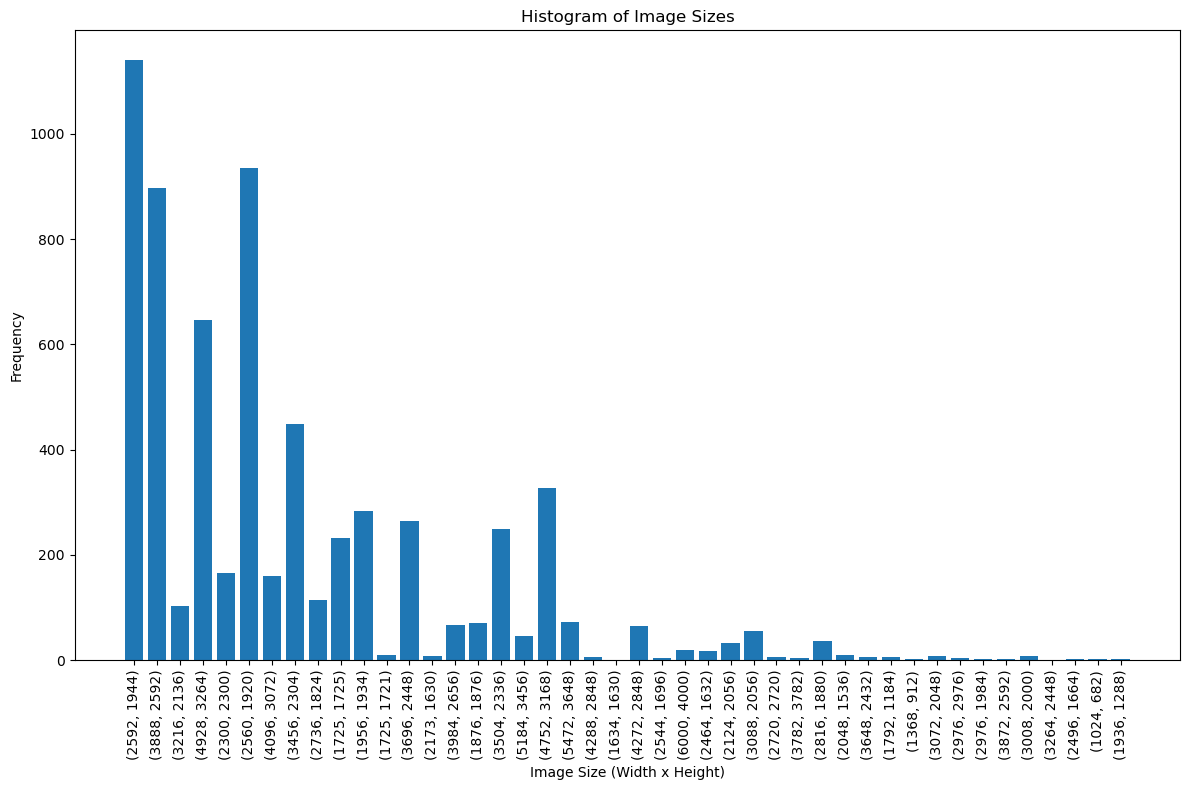

In [12]:
def get_image_sizes_and_counts(dataset_folder):
    image_sizes_count = defaultdict(int)

    # Iterate over all files in the dataset folder
    for filename in os.listdir(dataset_folder):
        if filename.endswith(".jpg"):
            # Read the image using OpenCV
            image_path = os.path.join(dataset_folder, filename)
            image = cv2.imread(image_path)

            if image is not None:
                # Get image dimensions (height and width)
                height, width, _ = image.shape

                # Record the image size (width x height)
                image_size = (width, height)
                image_sizes_count[image_size] += 1

    return image_sizes_count

def display_image_sizes_and_histogram(image_sizes_count):
    # Display a list of unique image sizes
    print("List of Different Image Sizes:")
    for image_size, count in image_sizes_count.items():
        print(f"Image Size: {image_size} | Count: {count}")

    # Create a histogram of image sizes occurrences
    sizes = list(image_sizes_count.keys())
    counts = list(image_sizes_count.values())

    plt.figure(figsize=(12, 8))
    plt.bar(range(len(sizes)), counts, align='center')
    plt.xticks(range(len(sizes)), sizes, rotation='vertical')
    plt.xlabel('Image Size (Width x Height)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Image Sizes')
    plt.tight_layout()
    plt.show()

# Example usage:
image_sizes_count = get_image_sizes_and_counts(folder_path)
display_image_sizes_and_histogram(image_sizes_count)


## !!!!!!!  CAUTION  !!!!!!! DO NOT RUN WITH A LARGE NUMBER OF DATA FILES IF YOU DON'T WANT TO WAIT

In [35]:
#output image folder path:
output_folder_path = "Glaucoma_Balanced_Dataset/Preprocessed_images_input_to_bound"

In [36]:
## This next block of code does just histogram equalization and normalization on the colorful part of the image(just the eye)
# The black background does not affect the equalization

In [37]:
# Specify the desired output size (e.g., 1956 x 1725)
target_width = 2048
target_height = 1024

In [38]:
# Function to resize the image while maintaining the aspect ratio
def resize_and_crop(image, target_width, target_height):
    # Get original image dimensions
    original_height, original_width, _ = image.shape
    original_aspect_ratio = original_width / original_height

    # Calculate target aspect ratio
    target_aspect_ratio = target_width / target_height

    # Determine resizing dimensions to fit the target aspect ratio
    if original_aspect_ratio > target_aspect_ratio:
        # Original image is wider, crop width
        new_width = int(original_height * target_aspect_ratio)
        cropped_image = image[:, (original_width - new_width) // 2 : (original_width + new_width) // 2, :]
    else:
        # Original image is taller, crop height
        new_height = int(original_width / target_aspect_ratio)
        cropped_image = image[(original_height - new_height) // 2 : (original_height + new_height) // 2, :, :]

    # Resize the cropped image to the target size
    resized_image = cv2.resize(cropped_image, (target_width, target_height))

    return resized_image

# Function to enhance image contrast and normalize non-black pixels
def enhance_and_normalize(image):
    # Convert image to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Threshold the L channel to create a mask of non-black pixels
    _, mask = cv2.threshold(l, 10, 255, cv2.THRESH_BINARY)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to the L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_eq = clahe.apply(l)

    # Merge the enhanced L channel back with the A and B channels using the mask
    enhanced_l = cv2.bitwise_and(l_eq, l_eq, mask=mask)
    lab_eq = cv2.merge((enhanced_l, a, b))

    # Convert LAB image back to RGB color space
    enhanced_image = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)

    # Normalize the intensity values of the enhanced image
    enhanced_image = cv2.normalize(enhanced_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    return enhanced_image

# Iterate over first 30 rows in the CSV file
for index, row in itertools.islice(data.iterrows(), 30):
    image_filename = row['Eye ID'] + ".jpg"  # The column containing the image filenames
    image_path = os.path.join(folder_path, image_filename)

    # Read the image
    image = cv2.imread(image_path)

    if image is not None:
        
        # Resize and crop the image to fit the target aspect ratio
        resized_image = resize_and_crop(image, target_width, target_height)

        # Enhance and normalize the resized image
        enhanced_image = enhance_and_normalize(resized_image)

        # Define the output path for the enhanced image
        output_filename = f"enhanced_{image_filename}"
        output_image_path = os.path.join(output_folder_path, output_filename)

        # Write the enhanced image to the output folder
        cv2.imwrite(output_image_path, enhanced_image)

        print(f"Enhanced image saved: {output_image_path}")


Enhanced image saved: Glaucoma_Balanced_Dataset/Preprocessed_images_input_to_bound\enhanced_TRAIN000000.jpg
Enhanced image saved: Glaucoma_Balanced_Dataset/Preprocessed_images_input_to_bound\enhanced_TRAIN000001.jpg
Enhanced image saved: Glaucoma_Balanced_Dataset/Preprocessed_images_input_to_bound\enhanced_TRAIN000002.jpg
Enhanced image saved: Glaucoma_Balanced_Dataset/Preprocessed_images_input_to_bound\enhanced_TRAIN000003.jpg
Enhanced image saved: Glaucoma_Balanced_Dataset/Preprocessed_images_input_to_bound\enhanced_TRAIN000004.jpg
Enhanced image saved: Glaucoma_Balanced_Dataset/Preprocessed_images_input_to_bound\enhanced_TRAIN000005.jpg
Enhanced image saved: Glaucoma_Balanced_Dataset/Preprocessed_images_input_to_bound\enhanced_TRAIN000006.jpg
Enhanced image saved: Glaucoma_Balanced_Dataset/Preprocessed_images_input_to_bound\enhanced_TRAIN000007.jpg
Enhanced image saved: Glaucoma_Balanced_Dataset/Preprocessed_images_input_to_bound\enhanced_TRAIN000008.jpg
Enhanced image saved: Glauco